<h1 align="center"> Malaria cell image classification</h1>
<center><img src="https://d12aarmt01l54a.cloudfront.net/cms/images/Media-20210105074112/1224-400.png" width="60%">

### Problem statement : 
Detect whether the given cell image is malaria infected or not.

### Machine Learning problem
 - Supervised Learning | Image Classification
 - Metrics : accuracy
 
### Source : 
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/

# Import modules
Importing all the necessary python modules

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
tf.__version__

'2.4.1'

# Data Splitting
Split the dataset into train and validation sets<br>
<b>Train set</b> : 80% of data<br>
<b>Test set</b> : 20% of data

In [29]:
WIDTH = 150
HEIGHT = 150
BATCH_SIZE = 128
TEST_SET_SIZE = 0.2 # 20%

generator = ImageDataGenerator(rescale=1/255.0, validation_split=TEST_SET_SIZE)

# Training data 
train_gen = generator.flow_from_directory(
    directory='../input/cell-images-for-detecting-malaria/cell_images/cell_images/',
    target_size=(WIDTH, HEIGHT),
    class_mode = 'binary',
    batch_size = BATCH_SIZE,
    subset='training')

# Testing data
val_gen = generator.flow_from_directory(
    directory='../input/cell-images-for-detecting-malaria/cell_images/cell_images/',
    target_size=(WIDTH,HEIGHT),
    class_mode = 'binary',
    batch_size = BATCH_SIZE,
    subset='validation')

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [30]:
# class labels
print(train_gen.class_indices)
print(val_gen.class_indices)

{'Parasitized': 0, 'Uninfected': 1}
{'Parasitized': 0, 'Uninfected': 1}


# Data Visualization

## Parasitized cells

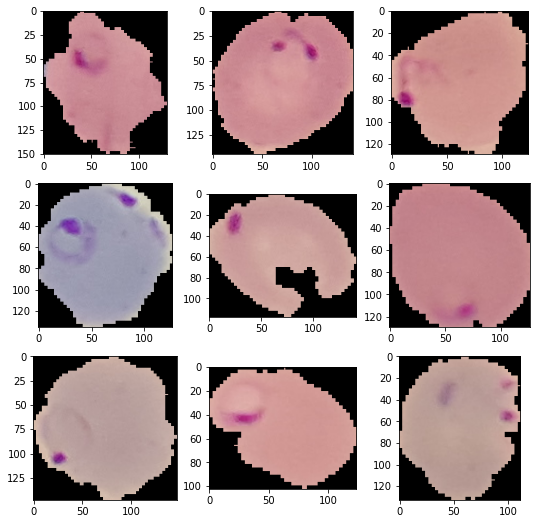

In [31]:
path = r'../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/'
n_images = 9
images = os.listdir(path)[:n_images]

f,axes = plt.subplots(3,3, figsize=(9,9))
axes = np.ravel(axes)
for i, img in enumerate(images):
    img = plt.imread(os.path.join(path,img))
    axes[i].imshow(img)
   

## Uninfected Images

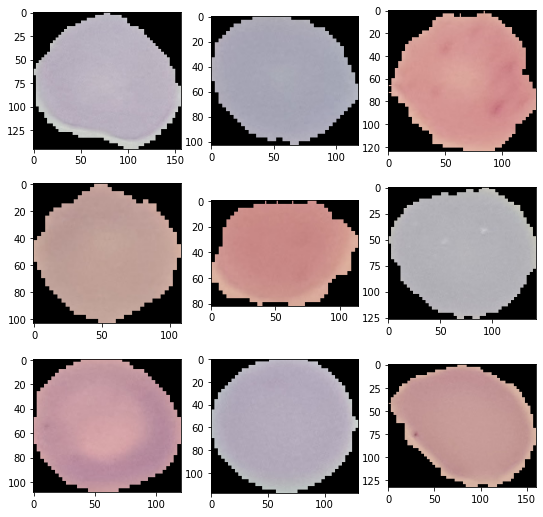

In [32]:
path = r'../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/'
n_images = 9
images = os.listdir(path)[:n_images]

f,axes = plt.subplots(3,3, figsize=(9,9))
axes = np.ravel(axes)
for i, img in enumerate(images):
    img = plt.imread(os.path.join(path,img))
    axes[i].imshow(img)
   

# Model Building (VGG)
We use VGG model Architecture and <b> customize it to our problem</b>.<br>
<img src="https://miro.medium.com/max/2400/1*Vz5n812l-J37a5wLxKbD8A.png" align="left" height="50%">

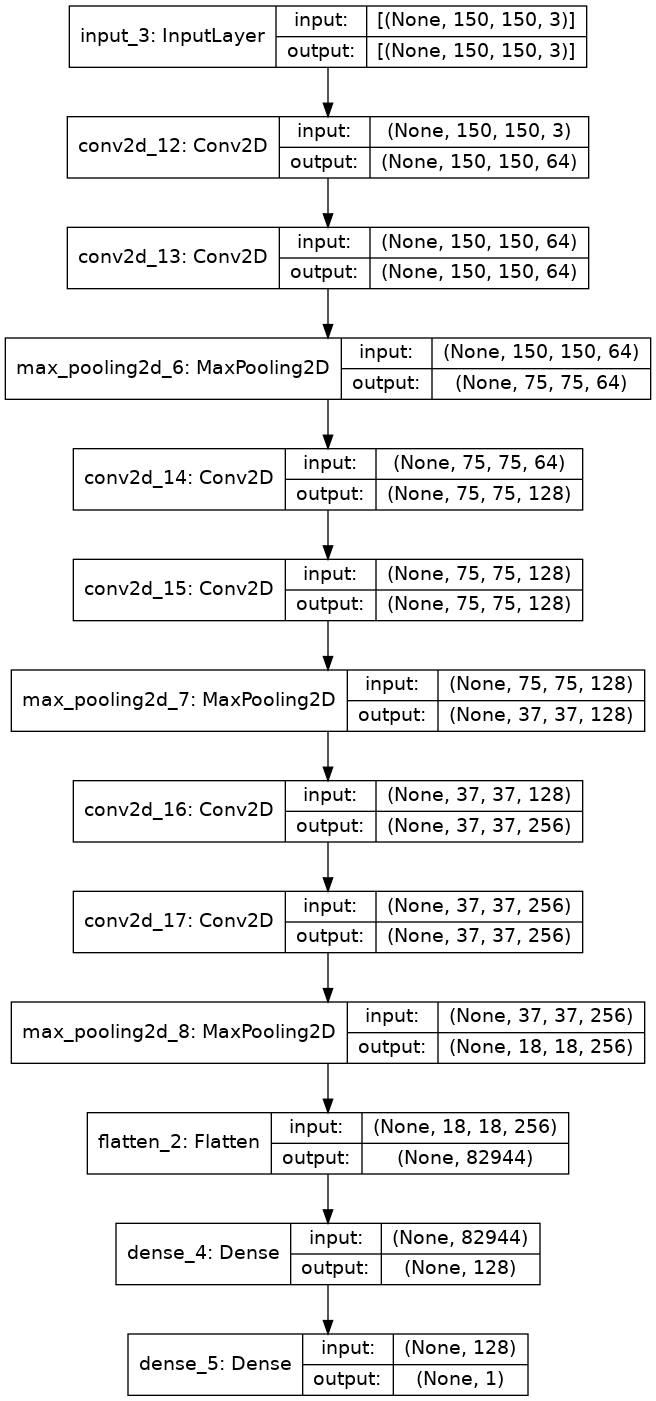

In [33]:
# function for creating a vgg block
def vgg_block(layer_in, n_filters, n_conv):
    # add convolutional layers
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in
 
# define model input
visible = Input(shape=(150, 150, 3))
# add vgg module
layer = vgg_block(visible, 64, 2)
# add vgg module
layer = vgg_block(layer, 128, 2)
# add vgg module
layer = vgg_block(layer, 256, 2)

x = Flatten()(layer)
x =(Dense(128, activation='sigmoid'))(x)

y = (Dense(1, activation='sigmoid'))(x)

# create model
model = Model(inputs=visible, outputs=y, name='VGG')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# plot model architecture
plot_model(model, show_shapes=True)

# Model Training

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
EPOCHS = 20

In [35]:
history = model.fit(train_gen,
                    epochs = EPOCHS,
                    validation_data = val_gen,
                    callbacks=[early_stopping])

Epoch 1/20
173/173 [==============================] - 260s 1s/step - loss: 0.6570 - accuracy: 0.5982 - val_loss: 0.1699 - val_accuracy: 0.9367
Epoch 2/20
173/173 [==============================] - 61s 350ms/step - loss: 0.1417 - accuracy: 0.9570 - val_loss: 0.1569 - val_accuracy: 0.9506
Epoch 3/20
173/173 [==============================] - 61s 352ms/step - loss: 0.1267 - accuracy: 0.9612 - val_loss: 0.1676 - val_accuracy: 0.9465
Epoch 4/20
173/173 [==============================] - 61s 354ms/step - loss: 0.1155 - accuracy: 0.9654 - val_loss: 0.1539 - val_accuracy: 0.9488
Epoch 5/20
173/173 [==============================] - 62s 359ms/step - loss: 0.1084 - accuracy: 0.9647 - val_loss: 0.1831 - val_accuracy: 0.9392
Epoch 6/20
173/173 [==============================] - 64s 367ms/step - loss: 0.1104 - accuracy: 0.9648 - val_loss: 0.1525 - val_accuracy: 0.9481
Epoch 7/20
173/173 [==============================] - 62s 356ms/step - loss: 0.0978 - accuracy: 0.9681 - val_loss: 0.1573 - val_accu

# Model Evaluation

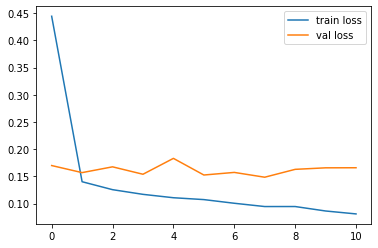

In [36]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

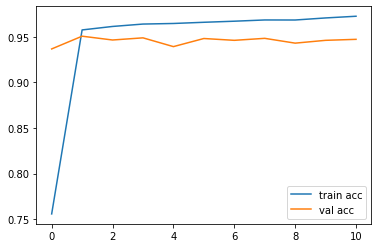

In [37]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

## Prediction on images

In [38]:
# function to predict class of given image
def predict(img):
    x = image.img_to_array(img)
    x = x/255.0
    x = np.expand_dims(x,axis=0)
    proba = model.predict(x)[0][0]
    y = "Uninfected" if proba > 0.5 else "Parasitized"
    return y

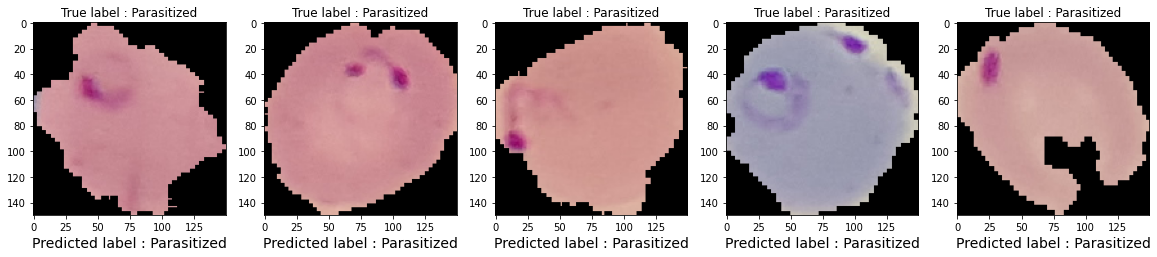

In [39]:
#prediction on parasitized images
path = r'../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/'
n_images = 5
images = os.listdir(path)[:n_images]
f,axes = plt.subplots(1,n_images, figsize=(20,4))
for i, img in enumerate(images):
    img = image.load_img(os.path.join(path, img),target_size=(150, 150))
    
    axes[i].imshow(img)
    
    axes[i].set_title("True label : Parasitized")
    pred = predict(img) # Prediction
    axes[i].set_xlabel(f"Predicted label : {pred}", fontsize=14)

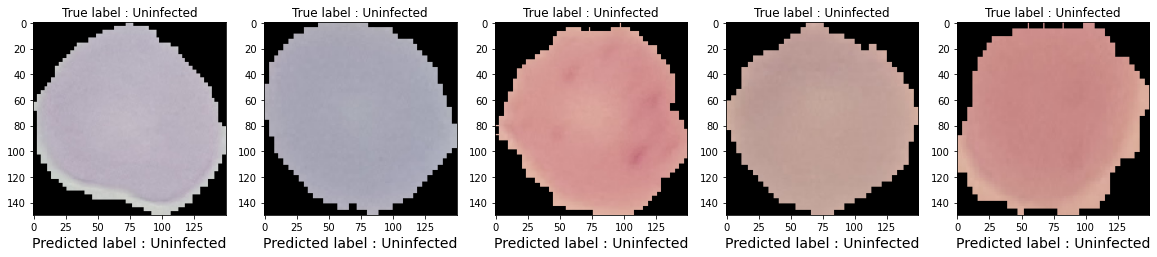

In [40]:
#prediction on uninfected images
path = r'../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/'
n_images = 5
images = os.listdir(path)[:n_images]
f,axes = plt.subplots(1,n_images, figsize=(20,4))
for i, img in enumerate(images):
    img = image.load_img(os.path.join(path, img),target_size=(150, 150))
    
    axes[i].imshow(img)
    
    axes[i].set_title("True label : Uninfected")
    pred = predict(img) # Prediction
    axes[i].set_xlabel(f"Predicted label : {pred}", fontsize=14)

# Save the model

In [41]:
model.save("vgg.h5")

## You can find the web application on my github

<b>Link : </b>https://github.com/ashok49473/malaria-detection-app

### Please upvote this kernel if you like my work!!

#### ----- Thank you.!! -----
